<a href="https://colab.research.google.com/github/itberrios/CV_projects/blob/main/fan_track.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Estmimate Anglular Motion of a Fan**

In this notebook, we will use Computer Vision technqiues to estimate the angular motion of a rotating fan

In [1]:

import os
import sys
import numpy as np
import cv2
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

Get fan video

In [2]:
!wget https://raw.githubusercontent.com/itberrios/CV_projects/main/fan.MOV

--2023-10-07 23:06:16--  https://raw.githubusercontent.com/itberrios/CV_projects/main/fan.MOV
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2065412 (2.0M) [video/quicktime]
Saving to: ‘fan.MOV’

fan.MOV             100%[===================>]   1.97M  --.-KB/s    in 0.05s   

2023-10-07 23:06:16 (36.6 MB/s) - ‘fan.MOV’ saved [2065412/2065412]



Get frames from fan video

In [3]:
video = cv2.VideoCapture("fan.MOV")

if (video.isOpened() == False):
    print("Error opening video file")

# get frame rate
fps = video.get(cv2.CAP_PROP_FPS)

frames = []
while(video.isOpened()):

    # read each video frame
    ret, frame = video.read()

    if ret == True:
        frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

    # Break if nothing is returned
    else:
        break

# clean up
video.release()
cv2.destroyAllWindows()
del video

## Get function to compute Optical Flow

In [571]:
idx = 3

frame1 = frames[idx]
frame2 = frames[idx + 1]

In [572]:
def filter_image(frame, iters=1):
    filtered = frame.copy()

    for i in range(iters):
      filtered = cv2.GaussianBlur(filtered, dst=None, ksize=(3,3), sigmaX=3)
      filtered = cv2.Laplacian(filtered, dst=None, ddepth=-1, ksize=1, scale=7, delta=1)
      filtered = cv2.GaussianBlur(filtered, dst=None, ksize=(5,5), sigmaX=5)
      filtered[filtered < 10] = 0
      filtered = cv2.convertScaleAbs(filtered, dst=None, alpha=10, beta=0)

    return filtered


def compute_flow(frame1, frame2):
    # convert to grayscale
    gray1 = cv2.cvtColor(frame1, cv2.COLOR_RGB2GRAY)
    gray2 = cv2.cvtColor(frame2, cv2.COLOR_RGB2GRAY)

    # blurr image
    gray1 = cv2.GaussianBlur(gray1, dst=None, ksize=(3,3), sigmaX=5)
    gray2 = cv2.GaussianBlur(gray2, dst=None, ksize=(3,3), sigmaX=5)

    flow = cv2.calcOpticalFlowFarneback(gray1, gray2, None,
                                        pyr_scale=0.5,
                                        levels=3,
                                        winsize=5,
                                        iterations=3,
                                        poly_n=10,
                                        poly_sigma=1.2,
                                        flags=0)

    return flow


def viz_flow(flow):
    hsv = np.zeros((flow.shape[0], flow.shape[1], 3)).astype(np.uint8)
    hsv[..., 1] = 255
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    hsv[..., 0] = ang*180/np.pi/2
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

    return rgb

In [573]:
flow = compute_flow(frame1, frame2)
rgb = viz_flow(flow)

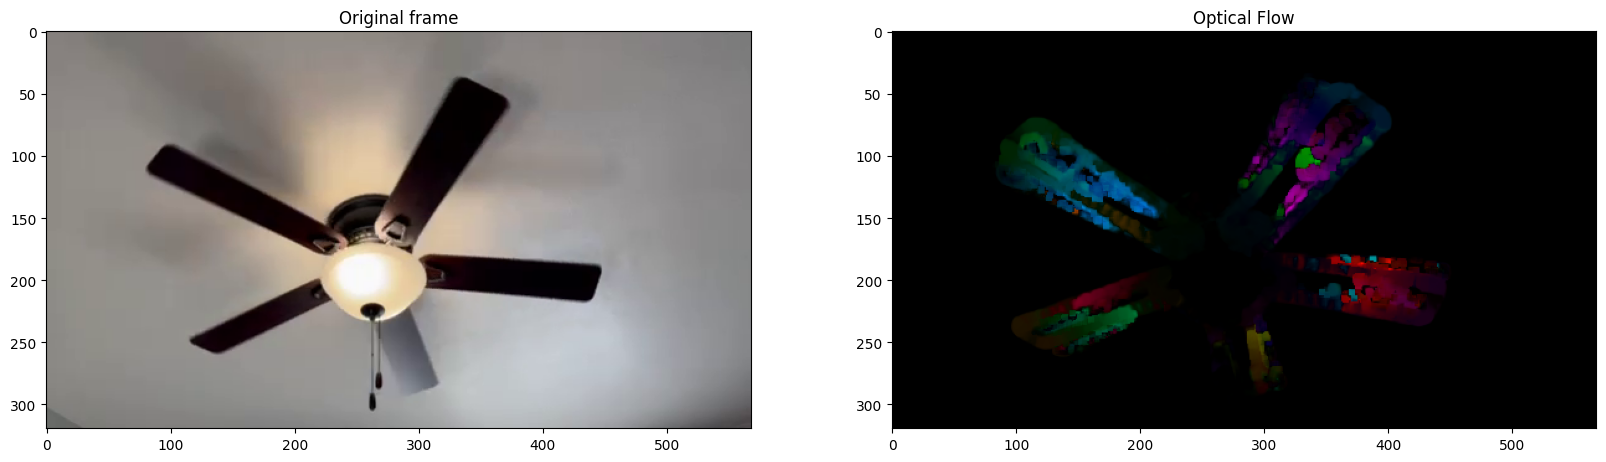

In [574]:
_, ax = plt.subplots(1, 2, figsize=(20,10))
ax[0].imshow(frame2)
ax[0].set_title('Original frame')
ax[1].imshow(rgb)
ax[1].set_title('Optical Flow');

Try line tracking?

In [575]:
frame = frame1.copy()
gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, dst=None, ksize=(3,3), sigmaX=3)
edges = cv2.Canny(gray,50,150,apertureSize=3)
# edges = filter_image(gray)
lines = cv2.HoughLinesP(edges,1,np.pi/180,100,minLineLength=100,maxLineGap=10)
for line in lines:
    x1,y1,x2,y2 = line[0]
    cv2.line(frame,(x1,y1),(x2,y2),(0,255,0),2)

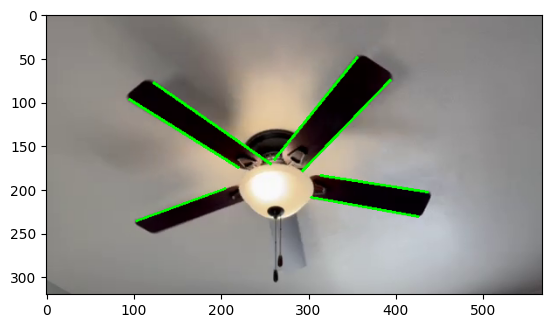

In [576]:
plt.imshow(frame)

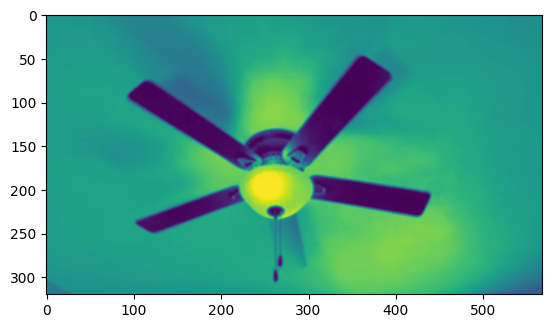

In [577]:
plt.imshow(gray)

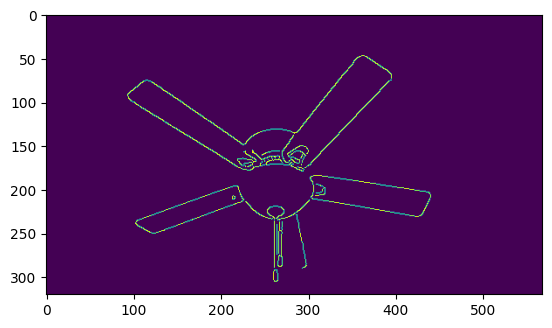

In [578]:
plt.imshow(edges)

In [579]:
def get_color(number):
    """ Converts an integer number to a color """
    # change these however you want to
    blue = number*30 % 256
    green = number*103 % 256
    red = number*50 % 256

    return red, blue, green


def get_hough_lines(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    gray = cv2.GaussianBlur(gray, dst=None, ksize=(3,3), sigmaX=3)
    edges = cv2.Canny(gray,50,150,apertureSize=3)
    lines = cv2.HoughLinesP(edges,1,np.pi/180,100,minLineLength=100,maxLineGap=20)
    return lines


# def flag_dup_lines(lines):
#     for line1 in lines:
#         for line2 in lines:



def draw_lines_green(image, lines):
    for line in lines:
        x1,y1,x2,y2 = line[0]
        cv2.line(image,(x1,y1),(x2,y2),(0,255,0),2)

    return image


def draw_lines(image, lines):
    for i, line in enumerate(lines, 1):
        x1,y1,x2,y2 = line[0]
        color = get_color(i*2.5)
        cv2.line(image,(x1,y1),(x2,y2),color,2)

    return image


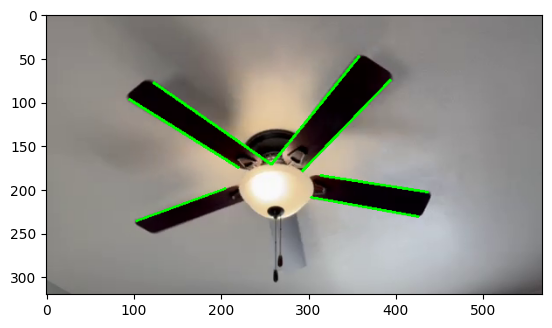

In [580]:
lines1 = get_hough_lines(frame1)
lines2 = get_hough_lines(frame2)

plt.imshow(draw_lines_green(frame1.copy(), lines1))

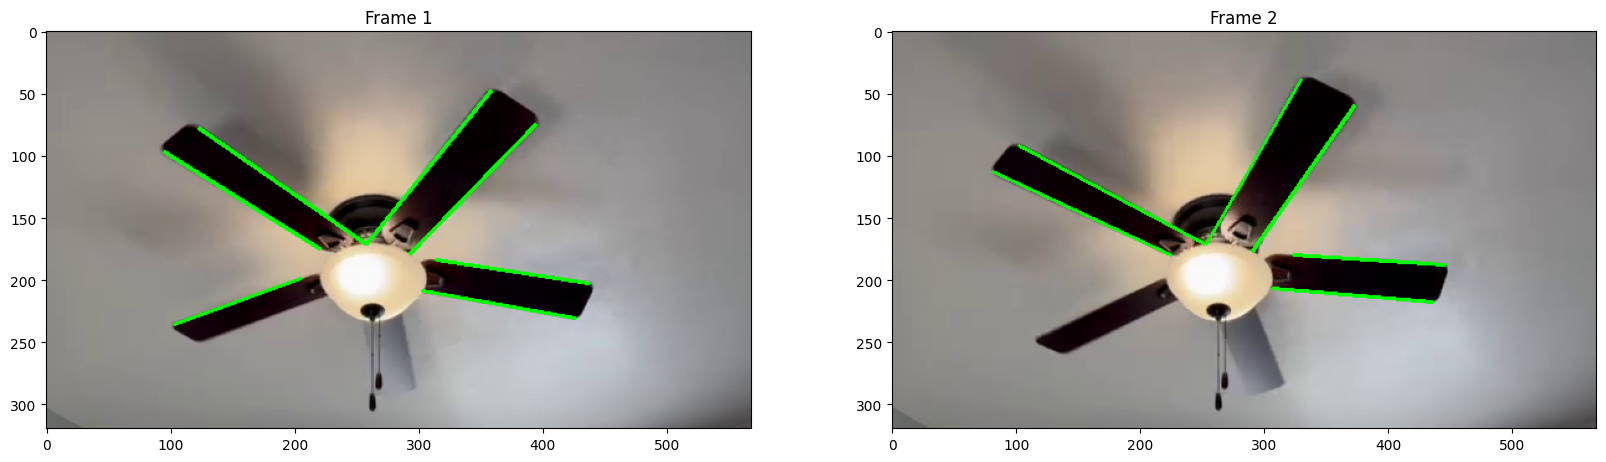

In [581]:
_, ax = plt.subplots(1, 2, figsize=(20,10))
ax[0].imshow(draw_lines_green(frame1.copy(), lines1))
ax[0].set_title('Frame 1')
ax[1].imshow(draw_lines_green(frame2.copy(), lines2)) # [2][None, ...]))
ax[1].set_title('Frame 2');

### Detection Helpers

In [582]:
from scipy.optimize import linear_sum_assignment

def compute_cost(line1, line2):
    x1,y1,x2,y2 = line1[0]
    u1,v1,u2,v2 = line2[0]

    l1 = np.array([x2 - x1, y2 - y1])
    l2 = np.array([u2 - u1, v2 - v1])

    # compute angle between lines
    theta = np.arccos(np.dot(l1, l2)/(np.linalg.norm(l1, ord=2) * np.linalg.norm(l2, ord=2)))
    # theta = np.dot(l1, l2)/(np.linalg.norm(l1, ord=2) * np.linalg.norm(l2, ord=2))

    # compute l2 norm
    l2_norm = np.linalg.norm(l1 - l2, ord=2)

    # return -np.dot(l1, l2) # + theta # + np.mean(np.square(line1 - line2))
    # return theta + np.mean(np.square(line1 - line2))
    # return l2_norm
    return theta + l2_norm # lower is better


def get_cost_mat(lines1, lines2):
  cost_mat = np.zeros((len(lines1), len(lines2)))
  for i, line1 in enumerate(lines1):
    for j, line2 in enumerate(lines2):
        cost_mat[i, j] = compute_cost(line1, line2)

  return cost_mat

def linear_assignment(cost_matrix):
    # ref: https://github.com/abewley/sort/blob/master/sort.py
    x, y = linear_sum_assignment(cost_matrix)
    return np.array(list(zip(x, y)))

In [583]:
cost_mat = get_cost_mat(lines1, lines2)

In [584]:
np.dot(np.array([1, 1]), np.array([3, 1]))

4

In [585]:
np.linalg.norm(np.array([3, 1]) - np.array([3, 1]), ord=2)

0.0

In [586]:
cost_mat

array([[ 21.21474562,  24.09118844, 201.20212841,  67.59211113,
         70.55665609, 217.247178  ],
       [ 27.68218351,  20.63747668, 217.90852621,  82.67393996,
         86.38410761, 234.01043214],
       [177.32055574, 190.47792732,  23.18119457, 119.2447183 ,
        114.81725546,  37.78501039],
       [196.13136189, 209.23381422,  19.04498915, 138.07539101,
        133.78813727,  25.79223036],
       [ 49.50545616,  62.96034596, 146.05715515,  12.62188878,
         14.14717905, 162.23780501],
       [112.57612264, 125.99539709,  83.07362588,  55.50572839,
         49.65775264,  99.19406391],
       [ 52.28489718,  65.72538645, 143.15852444,  10.06819466,
         11.13314119, 159.34715572]])

In [587]:
match_indexes = linear_assignment(cost_mat)

In [588]:
lines1, lines2

(array([[[ 95,  97, 220, 175]],
 
        [[123,  78, 257, 171]],
 
        [[293, 179, 394,  75]],
 
        [[258, 171, 358,  48]],
 
        [[303, 209, 426, 231]],
 
        [[103, 236, 205, 199]],
 
        [[314, 184, 437, 203]]], dtype=int32),
 array([[[ 81, 113, 224, 180]],
 
        [[102,  92, 251, 171]],
 
        [[290, 177, 372,  60]],
 
        [[306, 207, 435, 218]],
 
        [[323, 180, 445, 188]],
 
        [[253, 171, 329,  39]]], dtype=int32))

In [589]:
match_indexes

array([[0, 0],
       [1, 1],
       [2, 2],
       [3, 5],
       [4, 3],
       [6, 4]])

In [590]:
lines2

array([[[ 81, 113, 224, 180]],

       [[102,  92, 251, 171]],

       [[290, 177, 372,  60]],

       [[306, 207, 435, 218]],

       [[323, 180, 445, 188]],

       [[253, 171, 329,  39]]], dtype=int32)

In [591]:
lines1[match_indexes[:, 0]], lines2[match_indexes[:, 1]]

(array([[[ 95,  97, 220, 175]],
 
        [[123,  78, 257, 171]],
 
        [[293, 179, 394,  75]],
 
        [[258, 171, 358,  48]],
 
        [[303, 209, 426, 231]],
 
        [[314, 184, 437, 203]]], dtype=int32),
 array([[[ 81, 113, 224, 180]],
 
        [[102,  92, 251, 171]],
 
        [[290, 177, 372,  60]],
 
        [[253, 171, 329,  39]],
 
        [[306, 207, 435, 218]],
 
        [[323, 180, 445, 188]]], dtype=int32))

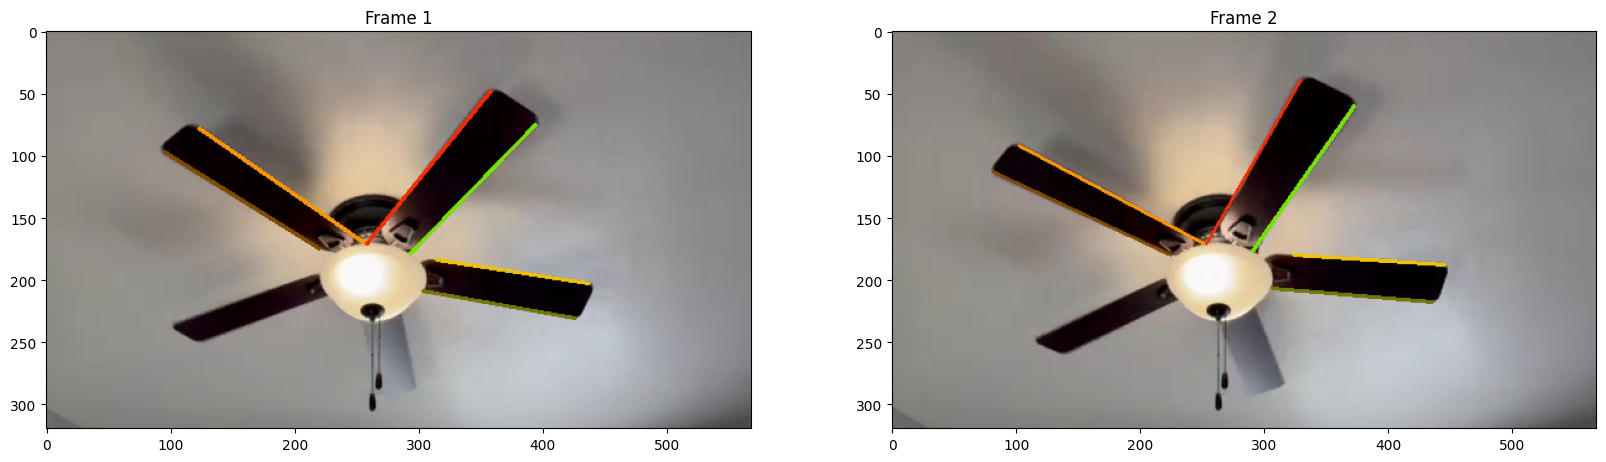

In [592]:
_, ax = plt.subplots(1, 2, figsize=(20,10))
ax[0].imshow(draw_lines(frame1.copy(), lines1[match_indexes[:, 0]]))
ax[0].set_title('Frame 1')
ax[1].imshow(draw_lines(frame2.copy(), lines2[match_indexes[:, 1]]))
ax[1].set_title('Frame 2');

## **Make Pipeline to perform Hungarian Tracking on detected Hough Lines**

In the next section, we will use this line association to finalize the tracking approach and determine the angular velocity of the fan!

First make a class to store line positions

In [611]:
class Line():
    def __init__(self, line, id_num):
       self.position_history = []
       self.x1 = line[0]
       self.y1 = line[1]
       self.x2 = line[2]
       self.y2 = line[3]
       self.id = id_num
       self.color = get_color(5*(self.id + 1))
       self.age = 0
       self.hit_streak = 0
       self.time_since_update


    def update(self, line):
       self.position_history.append(np.array([self.x1, self.y1, self.x2, self.y2]))
       self.x1 = line[0]
       self.y1 = line[1]
       self.x2 = line[2]
       self.y2 = line[3]

    def __call__(self):
        return np.array([[self.x1, self.y1, self.x2, self.y2]])

In [655]:
def draw(image, lines):
    for line in lines:
        cv2.line(image,(line.x1, line.y1), (line.x2, line.y2), line.color, 2)

    return image


In [671]:
def get_lines(_lines):
    lines = []
    for i, line in enumerate(_lines):
        lines.append(Line(line[0], id_num=i))
    return lines

In [674]:
frame = frames[0]
prev_lines = get_lines(get_hough_lines(frame))

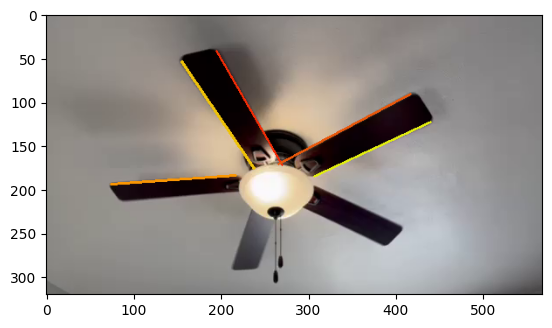

In [676]:
plt.imshow(draw(frame.copy(), prev_lines))

In [681]:
frame = frames[0]
prev_lines = get_hough_lines(frame)
matches = [prev_lines]

for i in range(1, len(frames)):
    frame = frames[i]

    # get Hough lines
    curr_lines = get_hough_lines(frame)

    # get matches
    cost_mat = get_cost_mat(prev_lines, curr_lines)
    match_indexes = linear_assignment(cost_mat)

    prev_matched_lines = prev_lines[match_indexes[:, 0]]
    matched_lines = curr_lines[match_indexes[:, 1]]
    matches.append(matched_lines)

    prev_lines = curr_lines.copy()



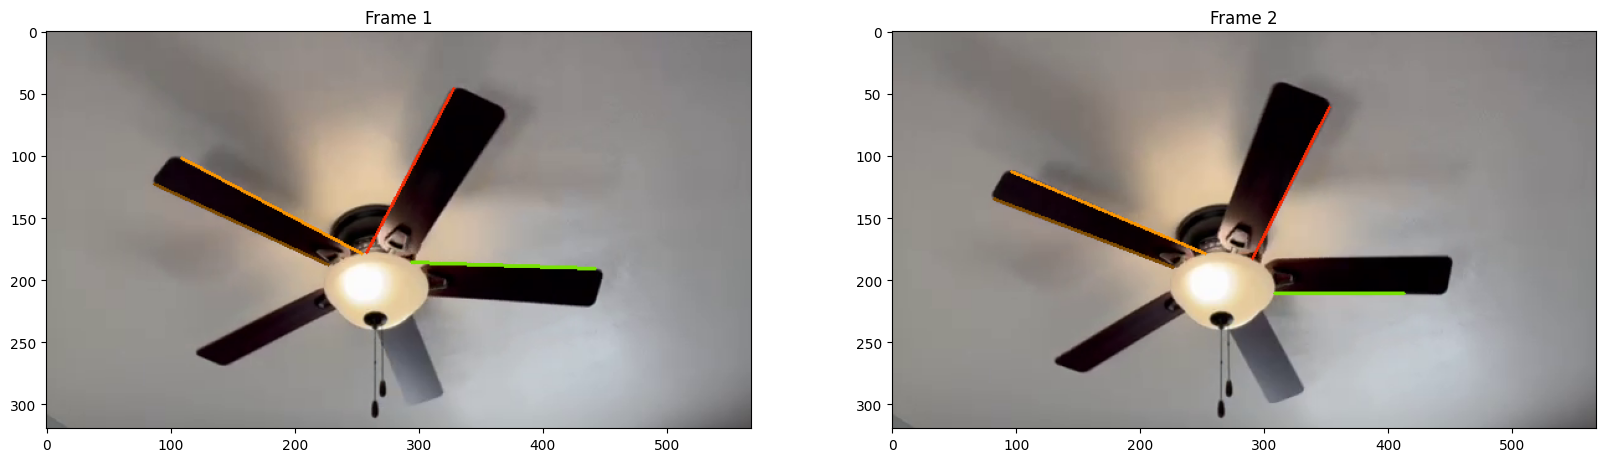

In [682]:
_, ax = plt.subplots(1, 2, figsize=(20,10))
ax[0].imshow(draw_lines(frames[i-1].copy(), prev_matched_lines))
ax[0].set_title('Frame 1')
ax[1].imshow(draw_lines(frame.copy(), matched_lines))
ax[1].set_title('Frame 2');

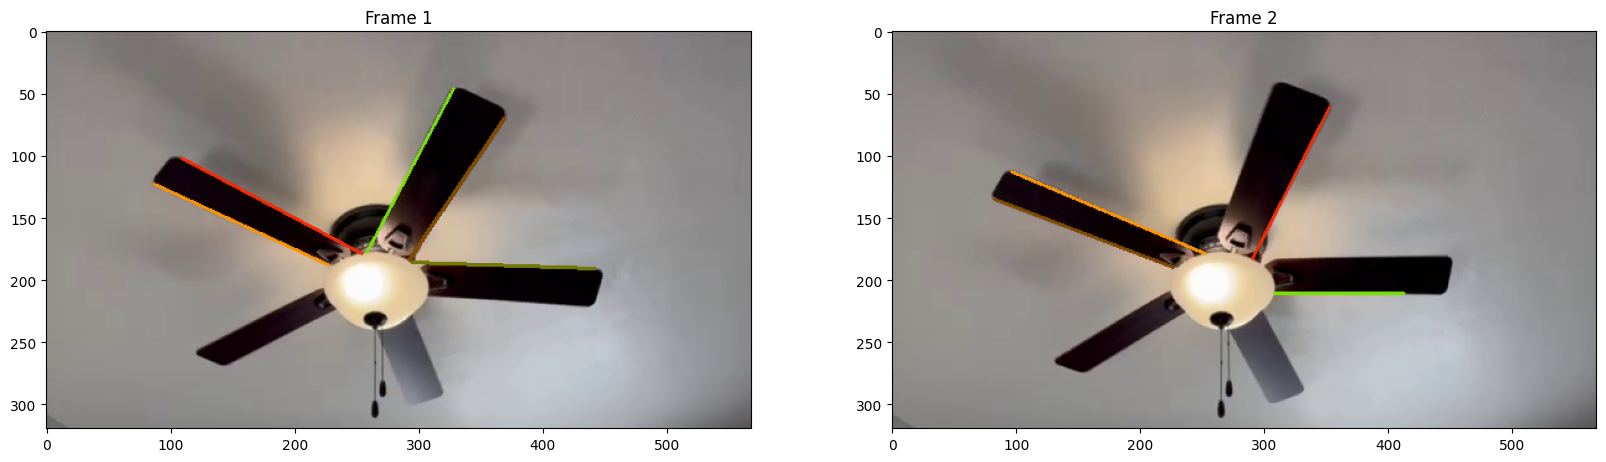

In [683]:
_, ax = plt.subplots(1, 2, figsize=(20,10))
ax[0].imshow(draw_lines(frames[i-1].copy(), matches[-2]))
ax[0].set_title('Frame 1')
ax[1].imshow(draw_lines(frame.copy(), matched_lines))
ax[1].set_title('Frame 2');

In [595]:
len(frames), len(matches)

(557, 557)

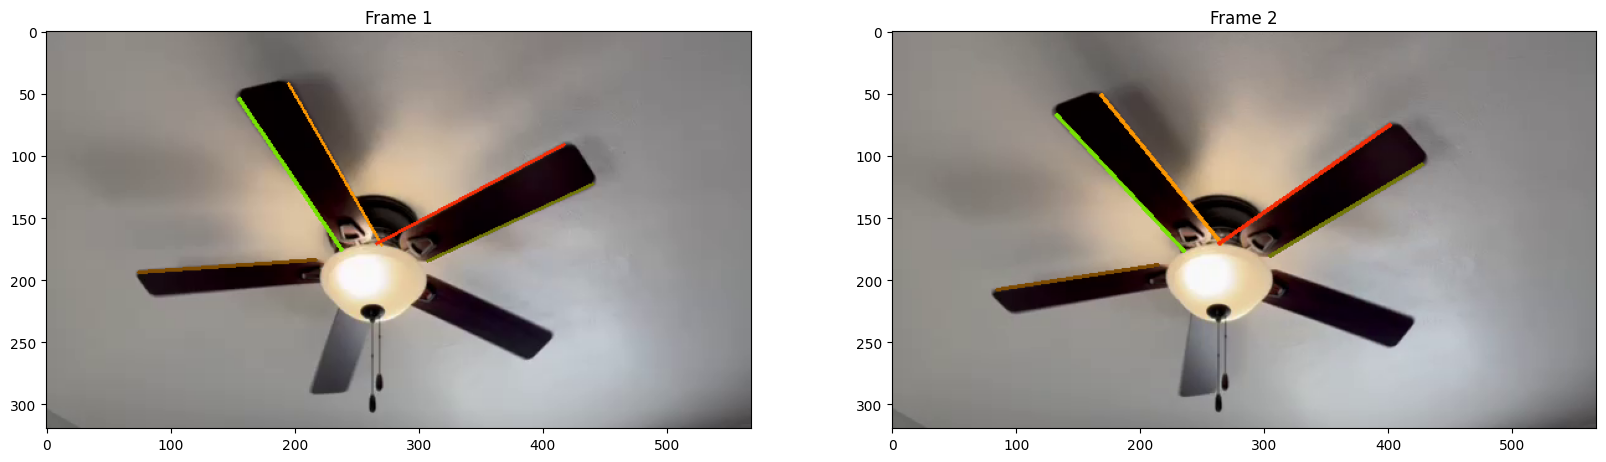

In [597]:
idx = 0

_, ax = plt.subplots(1, 2, figsize=(20,10))
ax[0].imshow(draw_lines(frames[idx].copy(), matches[idx]))
ax[0].set_title('Frame 1')
ax[1].imshow(draw_lines(frames[idx + 1].copy(), matches[idx + 1]))
ax[1].set_title('Frame 2');

In [737]:
def associate(detections, trackers, cost_thresh=100):
    unmatched_detections = []
    for d, det in enumerate(detections):
      if(d not in matched_indices[:,0]):
        unmatched_detections.append(d)

    unmatched_trackers = []
    for t, trk in enumerate(trackers):
      if(t not in matched_indices[:,1]):
        unmatched_trackers.append(t)

    #filter out matched with high cost
    matches = []
    for m in matched_indices:
      if(cost_mat[m[0], m[1]] > cost_thresh):
        unmatched_detections.append(m[0])
        unmatched_trackers.append(m[1])
      else:
        matches.append(m.reshape(1,2))
    if(len(matches)==0):
      matches = np.empty((0,2),dtype=int)
    else:
      matches = np.concatenate(matches,axis=0)

    return matches, np.array(unmatched_detections), np.array(unmatched_trackers)

In [738]:
from copy import deepcopy


min_hits = 0
max_age = 5
frame_count = 5

In [754]:
frame = frames[0]
trackers = get_hough_lines(frame)
line_trackers = get_lines(trackers)
history = [line_trackers] # ??

for i in range(1, len(frames)):
    frame = frames[i]

    # TEMP
    # print(trackers)

    # get Hough lines
    detections = get_hough_lines(frame)
    # curr_lines = get_lines(_curr_lines)

    # get matches
    cost_mat = get_cost_mat(detections, trackers)
    matched_indices = linear_assignment(cost_mat)

    # prev_matched_lines = prev_lines[match_indexes[:, 0]]
    # matched_lines = curr_lines[match_indexes[:, 1]]

    # # iterate through matches
    # curr_lines = []
    # for m1, m2 in match_indexes:
    #     prev_lines[m1].update(_curr_lines[m2][0])
    #     curr_lines.append(prev_lines[m1])

    matched, unmatched_dets, unmatched_trackers = associate(detections, trackers)

    for m in matched:
        line_trackers[m[1]].update(detections[m[0], :][0])

    for i in unmatched_dets:
        trk = Line(detections[i,:][0])
        line_trackers.append(trk)
    j = len(line_trackers)
    for trk in reversed(line_trackers):
        # remove dead tracklet
        if(trk.time_since_update > max_age):
          line_trackers.pop(j)



    # prep for next iteration
    trackers = [trk() for trk in line_trackers]

    # print(STOP)
    # matches.append(curr_lines)

    # # prep for next iteration
    # _prev_lines = deepcopy(_curr_lines)
    # prev_lines = deepcopy(curr_lines)

In [731]:
cost_mat

array([[127.37917301,  16.48405238,  67.52401629,  86.6832118 ,
         58.08847345, 138.85932452],
       [ 34.63856888, 160.96562042, 211.16012261, 236.2720287 ,
         99.51039365,  24.32261525],
       [ 23.47895289, 150.70211244, 201.55500575, 226.41224518,
         89.18733336,  14.22453643],
       [197.27483901,  63.90341443,  28.69005291,  20.73612666,
        125.41238511, 208.53997069],
       [175.85114375,  42.39057268,  15.72589813,  34.53726708,
        103.15745799, 186.85348863]])

In [765]:
idx = 0

_, ax = plt.subplots(1, 2, figsize=(20,10))
ax[0].imshow(draw_lines(frames[idx].copy(), matches[idx]))
ax[0].set_title('Frame 1')
ax[1].imshow(draw_lines(frames[idx + 1].copy(), matches[idx + 1]))
ax[1].set_title('Frame 2');

In [712]:
prev_lines

[None, None, None, None, None]

In [807]:
canvas = np.zeros_like(frame)

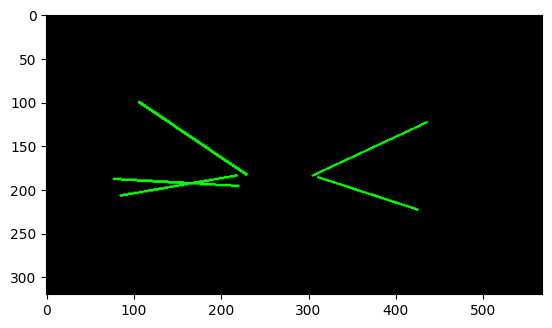

In [812]:
plt.imshow(draw_lines_green(canvas, line_trackers[0].position_history[400][None, None, ...]))

In [789]:
plt.imshow(draw_lines_green(canvas, line_trackers[5].position_history[0][None, None, ...]))

IndexError: ignored